$$
\\
\\
\LARGE\text{Short Term Trading Strategies from} \\
\LARGE\text{Mean Reversion of Yield Curve} \\
\\
$$
$$ \text{FINM 33150 | Quantitative Trading Strategies} $$
$$ \text{Winter 2023 | Prof. Brian Boonstra} $$
$$ \text{Final Project Draft} $$
\begin{aligned}
\small\text{Authors: Vidhan Ajmera}^1\small\text{, Ethan}&\small\text{ Ho}^2\small\text{, Joseph Padilla}^3\small\text{, Sam Tyler}^4
\end{aligned}

$$
\begin{aligned}
^1 \scriptsize\text{vidhanajmera@uchicago.edu }&\scriptsize\text{| Student ID: 12375227} \\
^2 \scriptsize\text{ethanho@uchicago.edu }&\scriptsize\text{| Student ID: 12350006} \\
^3 \scriptsize\text{jnpadilla@uchicago.edu }&\scriptsize\text{| Student ID: 12365617} \\
^4 \scriptsize\text{shtyler@uchicago.edu }&\scriptsize\text{| Student ID: 12276397} \\
\\
\end{aligned}
$$

$\textbf{Abstract }$
$\text{In this paper, we explore various short term trading strategies where yield curve reverts to its long term mean position, and we compare}$
$\text{ these strategies on various risk-return metrics such as profitability, return on capital, CVaR, Skewness etc.}$


$\textbf{Keywords: }$
$\text{yield curve, mean-reversion, treasuries, portfolio analysis.}$

<br>

In [1]:
!pip install --quiet quandl plotly git+https://github.com/ethho/memoize.git lmfit

In [2]:
import json
import re
import os
from glob import glob
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional
from joblib import Parallel, delayed
import functools
import multiprocessing
from multiprocessing import Pool
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm, probplot
import quandl
import plotly.express as px
import plotly.graph_objects as go
from memoize.dataframe import memoize_df
from lmfit.models import SkewedGaussianModel

%matplotlib inline
# pd.options.display.float_format = '{:,.4f}'.format

DARK_MODE = False
if DARK_MODE:
    plt.style.use('dark_background')
    plotly_template = 'plotly_dark'
else:
    plt.style.use('ggplot')
    plotly_template = 'ggplot2'

## Configuration & Helper Functions

The following cell contains helper functions and configuration options that I will use in this notebook.

In [128]:
def get_secrets(fp='./secrets.json'):
    """
    Reads secret values such as API keys from a JSON-formatted file at `fp`.
    """
    with open(fp, 'r') as f:
        data = json.load(f)
    return data

def get_quandl_api_key() -> str:
    """
    Returns Quandl API key stored in secrets.json.
    """
    secrets = get_secrets()
    key = secrets.get('NASTAQ_DATA_API_KEY')
    assert key, f"NASTAQ_DATA_API_KEY field in secrets.json is empty or does not exist"
    return key

def strip_str_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Given a DataFrame, strips values in columns with string or object
    dtype. I noticed that this was an issue when I saw some m_ticker values
    like "AAPL       " with trailing whitespace.
    """
    for col in df.columns:
        if pd.api.types.is_string_dtype(df[col]) or pd.api.types.is_object_dtype(df[col]):
            df[col] = df[col].str.strip()
    return df

@memoize_df(cache_dir='data/memoize', cache_lifetime_days=None)
def fetch_quandl_table(
    name, start_date, end_date, **kw
) -> pd.DataFrame:
    df = quandl.get_table(
        name,
        date={'gte': start_date, 'lte': end_date},
        api_key=get_quandl_api_key(),
        paginate=True,
        **kw
    )
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by='date', inplace=True)
    df.reset_index(inplace=True)
    return df

@memoize_df(cache_dir='data/memoize', cache_lifetime_days=None)
def fetch_quandl_quotemedia_prices(
    start_date, end_date, ticker
) -> pd.DataFrame:
    return fetch_quandl_table(
        name= 'QUOTEMEDIA/PRICES',
        start_date=start_date,
        end_date=end_date,
        ticker=ticker,
    )

@memoize_df(cache_dir='data/memoize', cache_lifetime_days=None)
def fetch_quandl_yc(
    name, start_date, end_date,
) -> pd.DataFrame:
    df = quandl.get(
        name,
        start_date=start_date,
        end_date=end_date,
        api_key=get_quandl_api_key(),
    ).reset_index().rename(columns={'Date': 'date'})
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by='date', inplace=True)
    return df

@memoize_df(cache_dir='data/memoize', cache_lifetime_days=None)
def fetch_quandl_spot(
    symbol, **kw
) -> pd.DataFrame:
    df = quandl.get(
        f'CUR/{symbol}',
        **kw
    ).reset_index().rename(columns={
        'DATE': 'date',
        'RATE': f'USD/{symbol}',
    })
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by='date', inplace=True)
    return df

def unique_index_keys(df, level=0) -> List[str]:
    return df.index.get_level_values(level=level).unique().tolist()

def get_next_day_of_week(date, day_of_week: int) -> str:
    """
    Monday = 0, Wednesday = 2
    """
    as_dt = pd.to_datetime(date)
    days_until = (day_of_week - as_dt.day_of_week) % 7
    out_dt = as_dt + pd.to_timedelta(days_until, 'D')
    return out_dt.strftime('%Y-%m-%d')

def get_standard_yc_cols(cols: List, col_prefix='') -> Dict:
    out = dict()
    for col_raw in cols:
        col = col_raw.lower()
        col = re.sub(r'-year', 'y', col)
        col = re.sub(r'-month', 'm', col)
        if col_prefix:
            col = col_prefix + '_' + col
        out[col_raw] = col
    return out

def get_yc(*args, col_prefix='', **kw):
    df = fetch_quandl_yc(*args, **kw)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    df.rename(columns=get_standard_yc_cols(df.columns, col_prefix), inplace=True)
    return df

@functools.lru_cache()
def get_col_groups(cols) -> Dict:
    """
    get_col_groups(tuple(yc_daily.columns.tolist()))
    """
    out = dict()
    for col in cols:
        prefix, tenor_raw = col.split('_')
        tenor, unit = tenor_raw[:-1], tenor_raw[-1]
        if prefix not in out:
            out[prefix] = list()
        item = {
            'col': col,
            'country': prefix,
            'tenor': tenor,
            'unit': unit
        }
        out[prefix].append(item)
    return out

def bond_price(zcb, coupon_rate, tenor, coupon_freq):
    """
    Adapted from Zero_And_Spot_Curves.ipynb
    """
    times = np.arange(tenor, 0, step=-coupon_freq)[::-1]
    if times.shape[0] == 0:
        p = 1.0
    else:
        r = np.interp(times, zcb.index.values, zcb.values) # Linear interpolation
        p = np.exp(-tenor*r[-1]) + coupon_freq * coupon_rate * np.exp(-r*times).sum()
    return p

def get_zcb_curve(spot, coupons_per_year=2, holding_period=30/360.):
    """
    Adapted from Zero_And_Spot_Curves.ipynb
    """
    print(spot)
    assert 0
    cpn_freq = 1 / float(coupons_per_year)
    for tenor, spot_rate in spot.items():
        if tenor <= 0.001:
            continue
        if tenor <= 1.:
            # US T-bills (<=1 year maturity) have no coupons
            spot.loc[tenor] = spot_rate
        else:
            times = np.arange(tenor-cpn_freq, 0, step=-cpn_freq)[::-1]
            coupon_half_yr = cpn_freq * spot_rate
            z = np.interp(times, spot.index.values, spot.values) # Linear interpolation
            preceding_coupons_val = (coupon_half_yr*np.exp(-z*times)).sum()
            spot.loc[tenor] = -np.log((1-preceding_coupons_val)/(1+coupon_half_yr))/tenor
        
    spot_copy = spot.copy()
    for tenor, spot_rate in spot.items():
        # Calculate bond price for maturities,
        # for example T = 5 years and S = 5 years - 1 week
        T = tenor
        S = T - holding_period
        tenor_name = str(int(tenor)) if tenor == int(tenor) else f"{tenor:0.2f}"
        spot.loc[f'{tenor_name}_rt'] = bond_price(spot_copy, coupon_rate=spot.loc[tenor], tenor=T, coupon_freq=cpn_freq)
        spot.loc[f'{tenor_name}_rs'] = bond_price(spot_copy, coupon_rate=spot.loc[tenor], tenor=S, coupon_freq=cpn_freq)
    return spot

def get_zcb_curves(row):
    # Get groups by column prefix
    grps: Dict[List[Dict]] = get_col_groups(tuple(row.columns.tolist()))
    zcb_dict = dict()
    for cty, cols in grps.items():
        df = pd.DataFrame.from_records(cols).convert_dtypes()
        df['tenor'] = df['tenor'].astype(int)
        df.set_index(['tenor', 'unit'], inplace=True)
        tenor_keys = [
            {
                'col': (1, 'm'),
                'years': 30 / 360.,
            },
            {
                'col': (3, 'm'),
                'years': 0.25,
            },
            {
                'col': (6, 'm'),
                'years': 0.5,
            },
            {
                'col': (1, 'y'),
                'years': 1,
            },
            {
                'col': (2, 'y'),
                'years': 2,
            },
            {
                'col': (3, 'y'),
                'years': 3,
            },
            {
                'col': (5, 'y'),
                'years': 5,
            },
            {
                'col': (7, 'y'),
                'years': 7,
            },
        ]
        tenor_years = [
            item['years'] for item in tenor_keys
        ]
        
        tenor_rates = list()
        for item in tenor_keys:
            ser = row[df.loc[item['col'], 'col']]
            ser.name = item['years']
            tenor_rates.append(ser)
        
        zcb = (pd.concat(tenor_rates, axis=1) / 100).apply(get_zcb_curve, axis=1)
        holding_period = 30/360.
        rename_dict = dict()
        for tenor in tenor_years:
            tenor_name = str(int(tenor)) if tenor == int(tenor) else f"{tenor:0.2f}"
            rename_dict[tenor] = f"{tenor_name}_zcb"
            T = tenor
            S = tenor - holding_period
            rt = zcb[f"{tenor_name}_rt"]
            rs = zcb[f"{tenor_name}_rs"]
            zcb[f'{tenor_name}_val'] = (
                (np.exp(-rs * S) / np.exp(-rt.shift(1) * T))
            )
            # zcb[f'{tenor_name}_ret'] = (zcb[f'{tenor_name}_val'] - zcb[f'{tenor_name}_val'].shift(1)) / zcb[f'{tenor_name}_val'].shift(1)
        zcb.rename(columns=rename_dict, inplace=True)
        zcb.index.name = 'date'
        zcb_dict[cty] = zcb
    return zcb_dict

# Fetch Data

First, let's set our time indices. We choose to trade weekly on Wednesdays, and skip the week if the Wednesday falls on a holiday.

In [129]:
start_date = '1990-01-01'
end_date = '2022-12-16'

daily_idx = pd.date_range(start_date, end_date)
first_wed = get_next_day_of_week(start_date, 2)
wed_idx_w_holidays = pd.date_range(first_wed, end_date, freq='7D')
assert all(date.day_of_week == 2 for date in wed_idx_w_holidays)

wed_idx = [
    date for date in wed_idx_w_holidays
    if date not in pd.to_datetime([
        # Remove Wednesdays that fall on holidays
        '2012-12-26', '2013-12-25', '2014-01-01', '2018-12-26',
        '2019-12-25', '2020-01-01',
    ])
]
assert len(wed_idx_w_holidays) > len(wed_idx)

Next, we'll use modified versions of the HW5 functions to calculate zero-coupon rates for U.S. Treasury bonds of the following maturities. We plan to trade primarily these 6 assets for our project, which puts us above the 5-asset minimum:

- 3 month
- 6 month
- 1 year
- 2 year
- 3 year
- 5 year

We make the following assumptions about coupons:

- Coupons are not given for T-bills, i.e. bonds with maturity of 1 year or less.
- Coupon yield is the same as the current yield for the note that it is given for.
- Coupons are distributed semi-annually.

In [130]:
countries = {
    'USA': 'USD',
}

yc_dict = {
    country: (
        get_yc(f'YC/{country}', start_date=start_date, end_date=end_date, col_prefix=country.lower())
        .reindex(daily_idx)
        .fillna(method='ffill')
        .iloc[1:, :]
    ) for country in countries.keys()
}
yc_daily = pd.concat(yc_dict.values(), axis=1)
yc_monthly = yc_daily.loc[wed_idx].copy()
zcb = get_zcb_curves(yc_monthly)
uszcb = zcb['usa']
uszcb

Using cache fp='data/memoize/fetch_quandl_yc_7609035_20230225.csv' to write results of function fetch_quandl_yc
Using cached call from data/memoize/fetch_quandl_yc_7609035_20230222.csv
0.083333       NaN
0.250000    0.0789
0.500000    0.0794
1.000000    0.0785
2.000000    0.0794
3.000000    0.0796
5.000000    0.0792
7.000000    0.0804
Name: 1990-01-03 00:00:00, dtype: float64


AssertionError: 

In [117]:
uszcb.columns

Index(['0.08_zcb', '0.25_zcb', '0.50_zcb', '1_zcb', '2_zcb', '3_zcb', '5_zcb',
       '7_zcb', '0.08_rt', '0.08_rs', '0.25_rt', '0.25_rs', '0.50_rt',
       '0.50_rs', '1_rt', '1_rs', '2_rt', '2_rs', '3_rt', '3_rs', '5_rt',
       '5_rs', '7_rt', '7_rs', '0.08_val', '0.25_val', '0.50_val', '1_val',
       '2_val', '3_val', '5_val', '7_val'],
      dtype='object')

A couple notes on notation here. Column prefixes denote the maturity. Column suffixes follow the conventions:

- `_zcb`: Zero-coupon yield. Same as the "dirty" yield for zero coupon bonds and T-bills.
- `_rs`: Bond price on the 0-month forward curve.
- `_rt`: Bond price on the 1-month forward curve.
- `_val`: Bond value assuming a 1-month holding period.

We can plot the yield curve for one point in time:

In [119]:
def unstack_zcb_df(in_df):
    df = in_df.copy()
    idx_df = pd.DataFrame(df.columns.str.split('_').tolist(), columns=['tenor', 'figure'])
    idx_df.tenor = idx_df.tenor.astype(float)
    idx_df.replace(0.08, 30/360., inplace=True)
    idx = pd.MultiIndex.from_frame(idx_df)
    df.columns = idx
    df = df.unstack().reorder_levels([1, 2, 0])
    return df

df = unstack_zcb_df(uszcb)
df

figure  date        tenor   
zcb     1990-01-03  0.083333         NaN
        1990-01-10  0.083333         NaN
        1990-01-17  0.083333         NaN
        1990-01-24  0.083333         NaN
        1990-01-31  0.083333         NaN
                                  ...   
val     2022-11-16  7.000000    1.062388
        2022-11-23  7.000000    1.066480
        2022-11-30  7.000000    1.063196
        2022-12-07  7.000000    1.066048
        2022-12-14  7.000000    1.063803
Length: 54848, dtype: float64

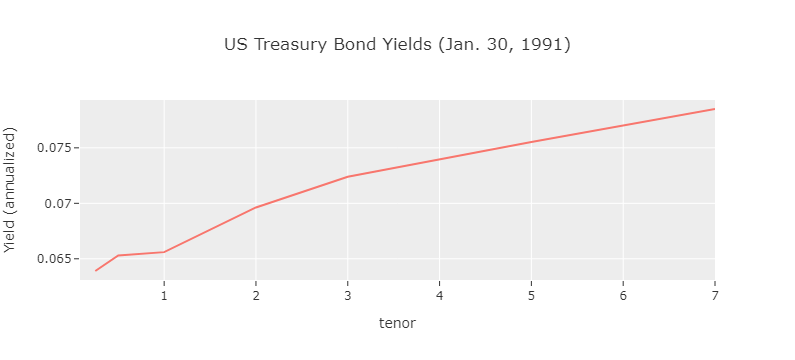

In [120]:
fig = px.line(
    df.loc['zcb', '1991-01-30', slice(None)],
    template=plotly_template,
    labels={
        'value': 'Yield (annualized)',
        'index': 'Tenor',
    },
    title="US Treasury Bond Yields (Jan. 30, 1991)",
)
fig.update_layout(showlegend=False)
fig

~~Note that the x axis in the above plot is not linear. We'll fix this in the full project, when we'll refactor the ZCB calculations into matrix math in numpy, so that the yield curve is just a 3-D matrix on continuous variables tenor, time, and yield.~~ Fixed, see above.

Like the Carry Trade homework, many of our trades require additional funding. In Strategy 1-A, for instance, we would buy all maturities on the curve using funds borrowed at the 1-month T-bill rate (plus 50 basis points).

# Strategy 1-A Preliminary Analysis

Mean yield of 1, 3, and 5-year rates:

In [9]:
mean_yield = uszcb[['usa_1y_zcb', 'usa_3y_zcb', 'usa_5y_zcb']].mean(axis=1)
mean_yield.head(3)

1990-01-03    0.077997
1990-01-10    0.077726
1990-01-17    0.079330
dtype: float64

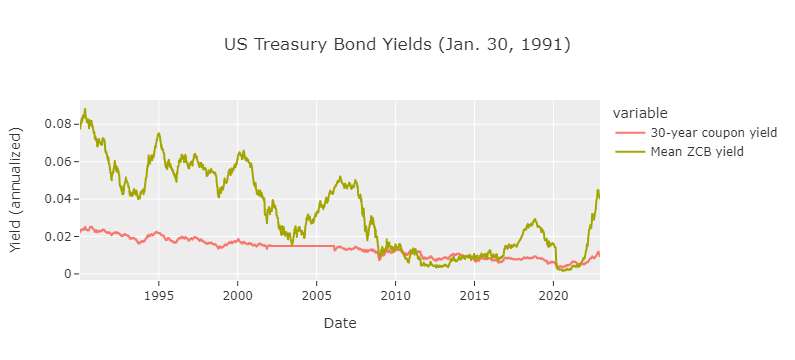

In [10]:
mean_vs_30_yc = (yc_monthly[['usa_30y']] / 360.).merge(
    mean_yield.to_frame('mean_zcb'),
    how='inner',
    left_index=True,
    right_index=True,
)
fig = px.line(
    mean_vs_30_yc.rename(columns={
        'usa_30y': '30-year coupon yield',
        'mean_zcb': 'Mean ZCB yield',
    }),
    template=plotly_template,
    labels={
        'value': 'Yield (annualized)',
        'index': 'Date',
    },
    title="US Treasury Bond Yields (Jan. 30, 1991)",
)
# fig.update_layout(showlegend=False)
fig

In [11]:
mean_vs_30_yc.corr()

,usa_30y,mean_zcb
usa_30y,1.000000,0.892623
mean_zcb,0.892623,1.000000


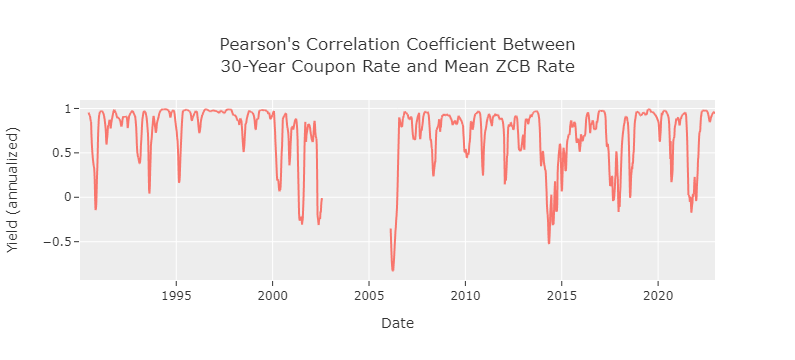

In [12]:
fig = px.line(
    mean_vs_30_yc['usa_30y'].rolling(24).corr(mean_vs_30_yc['mean_zcb']),
    template=plotly_template,
    labels={
        'value': 'Yield (annualized)',
        'index': 'Date',
    },
    title="Pearson's Correlation Coefficient Between<br>30-Year Coupon Rate and Mean ZCB Rate",
)
fig.update_layout(showlegend=False)
fig

As expected, the mean of 1, 3, and 5 year ZCB rates correlates strongly with interest rates overall, for which we use the 30-year coupon rate as a proxy.

In addition to the 1,3, and 5 year ZCB rates, this strategy will use 3,6, and 24 month tenors

In [13]:
mean_yield = uszcb[['usa_3m_zcb', 'usa_6m_zcb', 'usa_2y_zcb']].mean(axis=1)

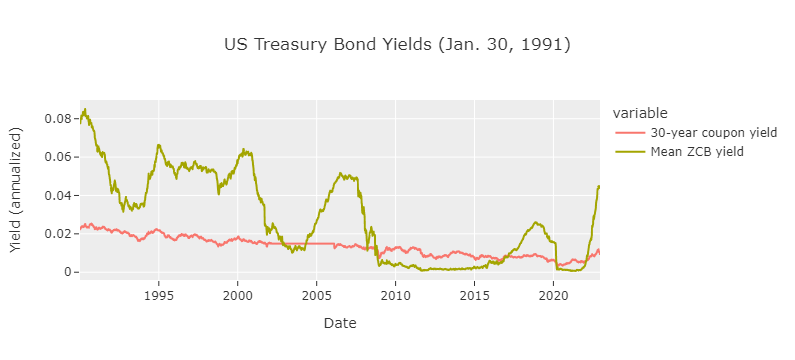

In [14]:
mean_vs_30_yc = (yc_monthly[['usa_30y']] / 360.).merge(
    mean_yield.to_frame('mean_zcb'),
    how='inner',
    left_index=True,
    right_index=True,
)
fig = px.line(
    mean_vs_30_yc.rename(columns={
        'usa_30y': '30-year coupon yield',
        'mean_zcb': 'Mean ZCB yield',
    }),
    template=plotly_template,
    labels={
        'value': 'Yield (annualized)',
        'index': 'Date',
    },
    title="US Treasury Bond Yields (Jan. 30, 1991)",
)
fig

In [15]:
mean_vs_30_yc.corr()

,usa_30y,mean_zcb
usa_30y,1.000000,0.824637
mean_zcb,0.824637,1.000000


Similarly, the 3,6 and 24 month ZCB correlate highly to interest rates, although slighly less than the 1,3, and 5 year ZCB's

# Strategy 2-A Preliminary Analysis

This strategy focuses on the mean reversion of the slope of the yield curve over the entire yield curve. For the purposes of this analysis, we examine the spread between the 3 month and 60 month T-notes as a signal for mean-reverting trade opportunities.

In [16]:
spread_360 = (uszcb['usa_5y_zcb'] - uszcb['usa_3m_zcb'])

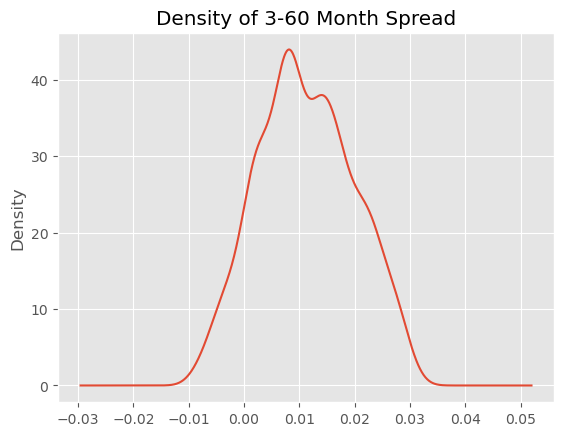

In [17]:
t2 = spread_360.plot(kind='density',xlabel='Spread',title='Density of 3-60 Month Spread')

In [18]:
print('Kurtosis of 3-60 Month Spread Distribution: ',spread_360.kurtosis())
print('Skew of 3-60 Month Spread Distribution: ', spread_360.skew())
sd2 = spread_360.std()*2
print('Proportion of data within 2 standard deviations (assuming Gaussian): ',(sum(spread_360 > (spread_360.mean() + sd2)) + sum(spread_360 < (spread_360.mean()-sd2))) / len(spread_360))

Kurtosis of 3-60 Month Spread Distribution:  -0.6711145754458951
Skew of 3-60 Month Spread Distribution:  0.07321577668717578
Proportion of data within 2 standard deviations (assuming Gaussian):  0.029171528588098017


The distribution of 3-60 month spreads appears to be approximately gaussian with very light tails and no significant skew. The negative kurtosis value indicates at platykurtic distribution, suggesting that the 3-60 month spread is heavily concentrated around the center of the distribution with very few large deviations. For this reason, we must be thoughtful about modeling the spread with light-tailed distributions in order to accurately calculate deviations to trade off of.

Since the trade will be executed by comparing the current yield spread to the spread of the historical curve, we quickly assess the deviations of current spreads from the historical spreads during our desired trading interval.

In [19]:
t = uszcb[['usa_3m_zcb','usa_5y_zcb']]
t['spread'] = t['usa_5y_zcb']- t['usa_3m_zcb']
t['avg_spread']= t['spread'].expanding().mean()

/tmp/ipykernel_19437/3845975508.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_19437/3845975508.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



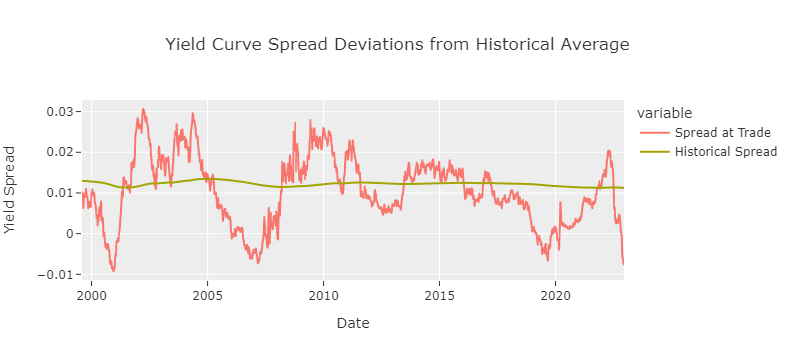

In [20]:
tt = t.drop(columns=['usa_3m_zcb','usa_5y_zcb'])
fig = px.line(
    tt.iloc[500:].rename(columns={
        'spread': 'Spread at Trade',
        'avg_spread': 'Historical Spread',
    }),
    template=plotly_template,
    labels={
        'value': 'Yield Spread',
        'index': 'Date',
    },
    title="Yield Curve Spread Deviations from Historical Average",
)
fig

We verify that there is indeed a mean-reverting trend in the slope, as defined by the 3-60 month spread, to historical levels. In further analysis, we can explore the use of smaller rolling windows to calculate historical averages instead of using the entire date range, in an attempt to produde more trade signals.

# Strategy 3-A Preliminary Analysis

For this strategy, the signal is a significant deviation in the difference between the slopes of two adjacent sections of the yield curve. As an example in our preliminary analysis, we calculate the slope of the curve between 3 and 5-year T-notes, and between 1 and 3-year notes:

In [21]:
slope_35 = (uszcb['usa_5y_zcb'] - uszcb['usa_3y_zcb']) / (5 - 3)
slope_13 = (uszcb['usa_3y_zcb'] - uszcb['usa_1y_zcb']) / (3 - 1)
slope_diff = slope_35 - slope_13
slope_diff.head(3)

1990-01-03    0.000053
1990-01-10   -0.000274
1990-01-17   -0.000183
dtype: float64

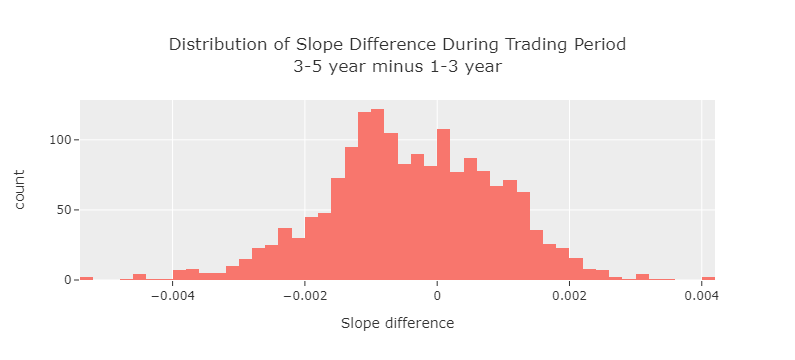

In [22]:
fig = px.histogram(
    slope_diff,
    template=plotly_template,
    labels={
        'count': 'Count',
        'value': 'Slope difference',
    },
    title='Distribution of Slope Difference During Trading Period<br>3-5 year minus 1-3 year',
)
fig.update_layout(showlegend=False)
fig

We can see that the difference in the slopes is roughly Gaussian with fat tails, and skews negative as our intuition would suggest (the 3-5 section of a yield curve usually has a smaller slope than the 1-3 section.

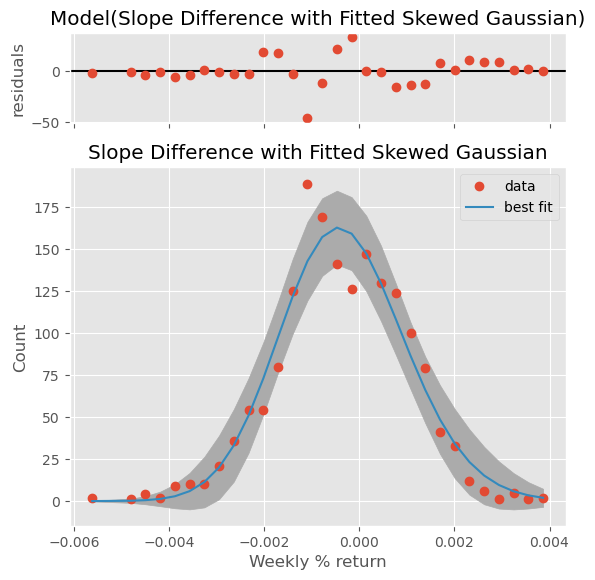

In [23]:
def fit_skewed_gaussian(ser_raw, title='', **kw):
    ser = ser_raw.value_counts(bins=30).sort_index()
    xvals = [idx.mid for idx in ser.index]
    yvals = ser.values
    # print(xvals)
    # print(yvals)
    model = SkewedGaussianModel()
    model.name = title
    params = model.make_params(**kw)
    result = model.fit(yvals, params, x=xvals)
    
    dely = result.eval_uncertainty(sigma=3)
    result.plot(xlabel='Weekly % return', ylabel='Count')
    plt.fill_between(xvals, result.best_fit-dely, result.best_fit+dely, color="#ABABAB",
                     label='3-$\sigma$ uncertainty band')
    plt.title(title)
    return result

result = fit_skewed_gaussian(slope_diff, title='Slope Difference with Fitted Skewed Gaussian')
result

Given this center and standard deviation (we omit $\gamma$ for the sake of simplicity for now), we can determine when in the studied period the slope difference was at least $2\sigma$ from the mean:

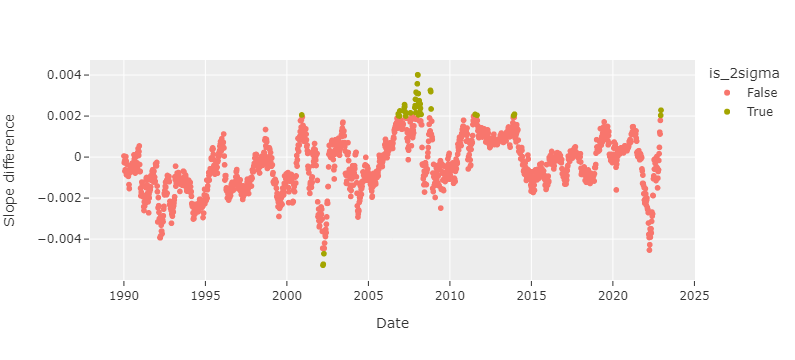

In [24]:
slope_df = slope_diff.to_frame('diff')
slope_df['is_2sigma'] = (slope_df['diff'] - result.params['center'].value).abs() > result.params['sigma'].value * 2
px.scatter(
    slope_df,
    y='diff',
    color='is_2sigma',
    template=plotly_template,
    labels={
        'diff': 'Slope difference',
        'index': 'Date',
    }
)

We noticed that these 2-sigma events in slope difference occur relatively infrequently, which would result in few trading signals. To address this, we plan to decrease (and parametrize) the multiplier in sigma from 2 to 1 or 1.5. In addition, we would determine the standard deviation with respect to the past $N$ periods, instead of the entire timeseries, which would increase signal frequency and eliminate the lookahead bias from using the whole series. This is sufficient for our preliminary analysis, since we can see that the difference in slope appears to mean-revert overall; this is one of the central ideas that motivates our project.

# Scratch